# Propensity Score Matching
The possibility of bias arises because a difference in the treatment outcome (such as the average treatment effect) between treated and untreated groups may be caused by a factor that predicts treatment rather than the treatment itself.  Matching attempts to reduce the treatment assignment bias, and mimic randomization, by creating a sample of units that received the treatment that is comparable on all observed covariates to a sample of units that did not receive the treatment.  PSM employs a predicted probability of group membership—e.g., treatment versus control group—based on observed predictors, usually obtained from logistic regression to create a counterfactual group. Propensity scores may be used for matching or as covariates, alone or with other matching variables or covariates.

PSM is the most widespread matching method, though some researchers caution about increased imbalance and degradation of inference (the PSM paradox) and recommend the use of Mahalanobis distance matching or coarsened exact matching [[2019 King, Nielsen](https://gking.harvard.edu/files/gking/files/pan1900011_rev.pdf)].

Here, we will try to see whether there are differences in alcohol consumption between people of different marital status (never married *vs.* married or divorced).  Our key data fields are:
* DEMO.DMDMARTL: marital status
* ALQ.ALQ121: "During the past 12 months, about how often did you drink any type of alcoholic beverage?"

Initially, we find that unmarried people drink significantly more.  However, marital status might be associated with age and gender.  When matching on age and gender is performed, the differences disappear.

![Graphical Abstract](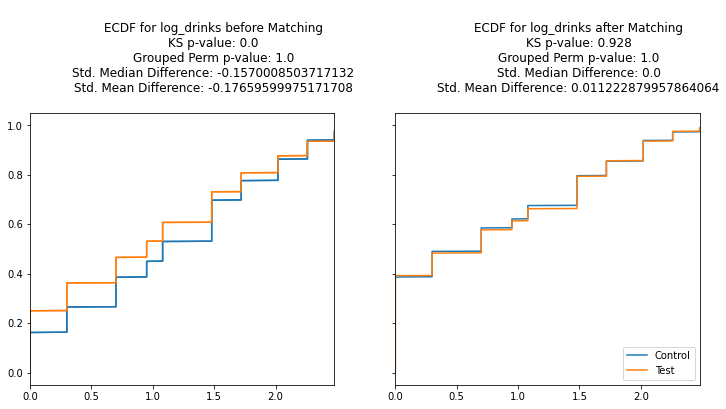%0A)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from scipy import stats

formatter = logging.Formatter(
    fmt='%(asctime)s.%(msecs)03d %(levelname)s [%(name)s] %(message)s',
    datefmt='%y%m%d@%H:%M:%S',
)

logger = logging.getLogger('pynhanes')
logger.setLevel(logging.DEBUG)
# f = logging.FileHandler('nhanes.log')
# f.setFormatter(formatter)
h = logging.StreamHandler(stream=sys.stdout)
h.setFormatter(formatter)

if not logger.hasHandlers():
    logger.addHandler(h)  # log to STDOUT or Jupyter
#     logger.addHandler(f)  # log to file

import pynhanes

210304@04:37:28.431 DEBUG [pynhanes] pynhanes package (re)loaded


In [ ]:
dfs = pynhanes.data.load(datasets=['DEMO','ALQ'], years=(2015, 2018))

210304@04:37:29.588 INFO [pynhanes.data] read 9971 rows x 47 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT
210304@04:37:30.635 INFO [pynhanes.data] read 9254 rows x 46 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT
210304@04:37:30.647 INFO [pynhanes.data] combined dataset DEMO: 19225 rows x 52 cols
210304@04:37:30.929 INFO [pynhanes.data] read 5735 rows x 10 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.XPT
210304@04:37:31.206 INFO [pynhanes.data] read 5533 rows x 10 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.XPT
210304@04:37:31.211 INFO [pynhanes.data] combined dataset ALQ: 11268 rows x 18 cols


In [ ]:
df = pd.merge(
    left = dfs['DEMO'],
    right = dfs['ALQ'],
    on = ['SEQN','year'],
    how = 'inner',
)
df.shape

(11268, 68)

In [ ]:
# # Recoding ALQ121 answers into numbers

# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 0	Never in the last year	1049	1049	ALQ151
# 1	Every day	142	1191	
# 2	Nearly every day	155	1346	
# 3	3 to 4 times a week	273	1619	
# 4	2 times a week	323	1942	
# 5	Once a week	340	2282	
# 6	2 to 3 times a month	606	2888	
# 7	Once a month	351	3239	
# 8	7 to 11 times in the last year	299	3538	
# 9	3 to 6 times in the last year	476	4014	
# 10	1 to 2 times in the last year	527	4541	
# 77	Refused	2	4543	
# 99	Don't know	2	4545	
# .	Missing	988	5533	

ALQ121_categories = sorted(df.ALQ121.unique())
drinks_per_year = [np.nan, 1, 365, 300, 183, 104, 52, 30, 12, 9, 5, 2, np.nan, np.nan]
drinks = {k: v for k, v in zip(ALQ121_categories, drinks_per_year)}
df['drinks'] = df.ALQ121.map(drinks)
df['log_drinks'] = np.log10(df['drinks']).round(2)

f1 = df.DMDMARTL.isin([1,3,5])  # 1 = married, 3 = divorced, 5 = never married
f2 = df.log_drinks >= 0

dr = df.loc[f1 & f2, ['RIAGENDR','RIDAGEYR','DMDMARTL','log_drinks',]]  #'INDFMPIR',]]
dr['RIAGENDR'] = dr['RIAGENDR'].map({1: 1, 2: 0})   # 0 = F, 1 = M
# dr['DMDMARTL'] = dr['DMDMARTL'].map({1: 0, 3: 1})   # 0 = married, 1 = divorced
dr['DMDMARTL'] = dr['DMDMARTL'].map({5: 0, 1: 1, 3: 1})   # 0 = never married, 1 = married or divorced
dr.shape

(3460, 4)

In [ ]:
# TODO: impute DEMO.INFDMPIR
dr.isna().sum()

RIAGENDR      0
RIDAGEYR      0
DMDMARTL      0
log_drinks    0
dtype: int64

In [ ]:
gender_by_maritalstatus = dr.groupby('DMDMARTL').RIAGENDR.describe()
gender_by_maritalstatus

,count,mean,std,min,25%,50%,75%,max
DMDMARTL,,,,,,,,
0,796.0,0.518844,0.499959,0.0,0.0,1.0,1.0,1.0
1,2664.0,0.539039,0.498567,0.0,0.0,1.0,1.0,1.0


In [ ]:
logdrinks_by_maritalstatus = dr.groupby('DMDMARTL').log_drinks.describe()
logdrinks_by_maritalstatus

,count,mean,std,min,25%,50%,75%,max
DMDMARTL,,,,,,,,
0,796.0,1.145992,0.795110,0.0,0.300,1.08,1.72,2.56
1,2664.0,0.999767,0.834961,0.0,0.225,0.95,1.72,2.56


In [ ]:
dr

,RIAGENDR,RIDAGEYR,DMDMARTL,log_drinks
5735,0,66.0,1,1.08
5739,1,56.0,1,1.72
5741,1,67.0,1,1.48
5742,0,54.0,1,0.70
5743,1,71.0,1,0.00
...,...,...,...,...
11256,1,48.0,1,1.72
11259,1,55.0,1,1.08
11261,1,75.0,1,0.70
11264,0,70.0,1,0.00


## Checking for differences
Seems like there is no difference in `log_drinks` between married and divorced people.  But wait!..

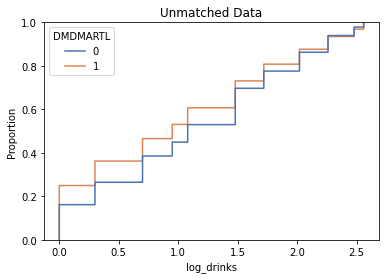

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
# # sns.boxplot(x='RIAGENDR', y='log_drinks', hue='DMDMARTL', data=dr)
sns.ecdfplot(data=dr, x="log_drinks", hue="DMDMARTL", palette="deep", ax=ax)
ax.set_title("Unmatched Data")
plt.show()

In [ ]:
test = dr[dr.DMDMARTL == 1].copy()
control = dr[dr.DMDMARTL == 0].copy()

In [ ]:
print(stats.ttest_ind(test.log_drinks, control.log_drinks))
print(stats.mannwhitneyu(test.log_drinks, control.log_drinks))

Ttest_indResult(statistic=-4.382720315739331, pvalue=1.2069086630411861e-05)
MannwhitneyuResult(statistic=948272.0, pvalue=2.4103262220651153e-06)


## There is a significant association between marital status and age

In [ ]:
print(stats.ttest_ind(test.RIDAGEYR, control.RIDAGEYR))
print(stats.mannwhitneyu(test.RIDAGEYR, control.RIDAGEYR))

Ttest_indResult(statistic=31.060149158739318, pvalue=4.918807596321285e-187)
MannwhitneyuResult(statistic=394913.5, pvalue=8.481055037126749e-160)


## Let's match!
Propensity score matching with PyMatch

In [ ]:
%%bash
# must tweak source code: https://github.com/benmiroglio/pymatch/issues/23
sed -i 's/y == preds/y.to_numpy().T == preds/1' ~/venv/lib/python3.7/site-packages/pymatch/Matcher.py
grep "== preds" ~/venv/lib/python3.7/site-packages/pymatch/Matcher.py

        return (y.to_numpy().T == preds).sum() * 1.0 / len(y)


In [ ]:
from pymatch.Matcher import Matcher
m = Matcher(test, control, yvar="DMDMARTL", exclude=[])

Formula:
DMDMARTL ~ RIAGENDR+RIDAGEYR+log_drinks
n majority: 2664
n minority: 796


Fitting Models on Balanced Samples: 10\10
Average Accuracy: 72.64%
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


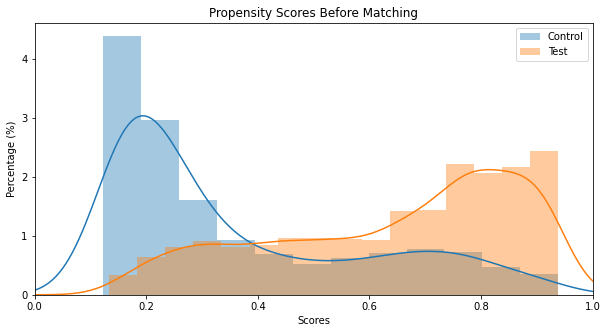

In [ ]:
np.random.seed(20210303)
m.fit_scores(balance=True, nmodels=10)
m.predict_scores()
m.plot_scores()

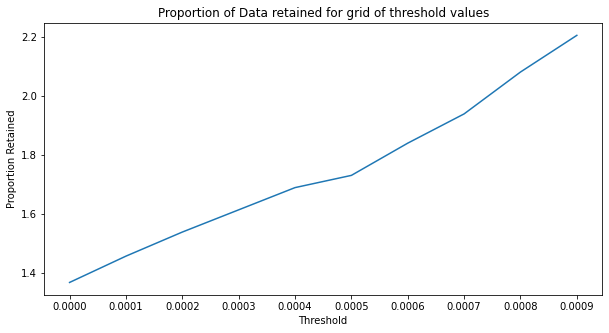

In [ ]:
m.tune_threshold(method='random')  #, rng=np.arange(0, 1e-6, 1e-7))

In [ ]:
m.match(method="random", nmatches=1, threshold=0.0001)
m.record_frequency()

,freq,n_records
0,1,1331
1,2,103
2,3,67
3,4,37
4,5,14
5,6,14
6,7,7
7,8,3
8,9,5
9,10,3


In [ ]:
m.assign_weight_vector()
m.matched_data.sort_values("match_id").head(8)

,record_id,weight,RIAGENDR,RIDAGEYR,DMDMARTL,log_drinks,scores,match_id
0,1,1.000000,1,56.0,1,1.72,0.700578,1
1353,2787,0.125000,1,56.0,0,1.72,0.700578,1
1,3,1.000000,0,54.0,1,0.70,0.655398,3
1165,2671,1.000000,0,54.0,0,0.70,0.655398,3
2,4,1.000000,1,71.0,1,0.00,0.859023,4
2303,3458,0.071429,1,71.0,0,0.00,0.859023,4
3,10,1.000000,1,53.0,1,2.48,0.666998,10
1474,2884,1.000000,1,53.0,0,2.48,0.666998,10


In [ ]:
m.matched_data.groupby('DMDMARTL').weight.value_counts()

DMDMARTL  weight  
0         0.500000     206
          0.333333     201
          1.000000     172
          0.250000     148
          0.166667      84
          0.200000      70
          0.142857      49
          0.111111      45
          0.090909      33
          0.033333      30
          0.100000      30
          0.125000      24
          0.047619      21
          0.058824      17
          0.066667      15
          0.071429      14
1         1.000000    1159
Name: weight, dtype: int64

In [ ]:
# we picked 1159 matched pairs
m.matched_data.match_id.value_counts().value_counts()
# m.matched_data.DMDMARTL.value_counts()

2    1159
Name: match_id, dtype: int64

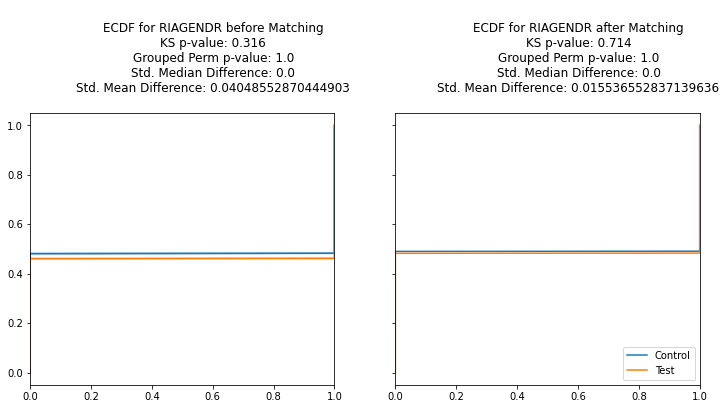

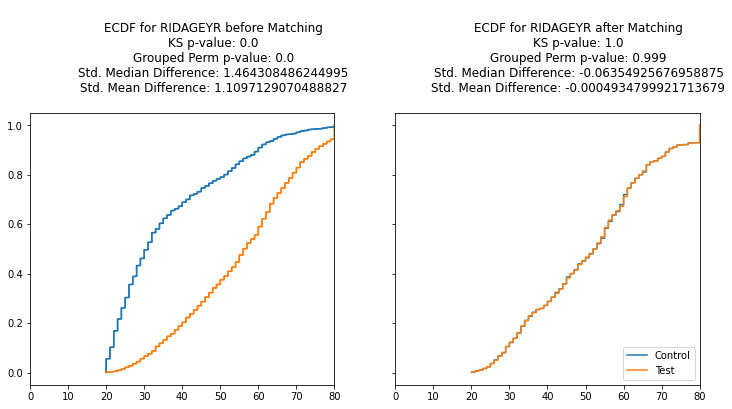

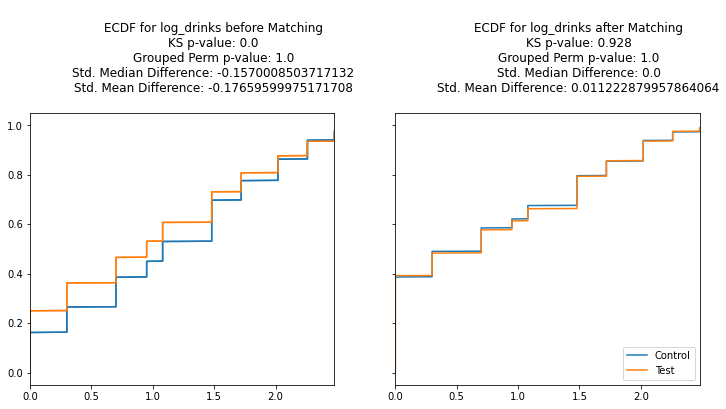

In [ ]:
cc = m.compare_continuous(return_table=True)

## The differences disappeared!

In [ ]:
print(stats.ttest_ind(m.matched_data.query('DMDMARTL == 1').log_drinks, m.matched_data.query('DMDMARTL == 0').log_drinks))
print(stats.mannwhitneyu(m.matched_data.query('DMDMARTL == 1').log_drinks, m.matched_data.query('DMDMARTL == 0').log_drinks))

Ttest_indResult(statistic=0.2700538898333542, pvalue=0.7871428554369482)
MannwhitneyuResult(statistic=669554.5, pvalue=0.446792128696086)


## Sandbox

In [ ]:
# ALQ = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.XPT')
# DEMO = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT')

# url = 'https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Laboratory&CycleBeginYear=2017'
# df = pd.read_html(url)[0]  # attrs={'id':'GridView1'}

# import requests
# r = requests.get(url)
# lines = r.content.decode('utf-8').split('\n')
# [l.split('"')[1] for l in lines if '.XPT' in l]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=98f37550-cbaa-491c-a3ea-f393696dc041' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>